**Importing Libraries**

In [66]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

**Loading the dataset**

In [67]:
# Loading the dataset
file_path = '/content/gtrends.csv'
data = pd.read_csv(file_path)

**Overview of the data**

In [77]:
#Data Overview
print(data.head())
print(data.info())
print(data.describe())

                       Trends Search volume                   Started Ended  \
0        new zealand vs india           5M+ 2024-10-24 09:00:00-05:30   NaN   
1  south africa vs bangladesh           1M+ 2024-10-29 09:00:00-05:30   NaN   
2   krishnakumar kunnath 'kk'           2M+ 2024-10-25 00:00:00-05:30   NaN   
3            elcid investment         200K+ 2024-10-29 09:50:00-05:30   NaN   
4                    do patti         500K+ 2024-10-24 23:40:00-05:30   NaN   

                                     Trend breakdown  \
0        new zealand vs india,mca,3rd test ind vs nz   
1  south africa vs bangladesh,tony de zorzi,trist...   
2  krishnakumar kunnath 'kk',kk,krishnakumar kunn...   
3  elcid investment,elcid investment share,elcid ...   
4  do patti,do patti review,kriti sanon,do patti ...   

                                        Explore link  Search volume (numeric)  \
0  https://trends.google.com/trends/explore?q=new...                5000000.0   
1  https://trends.google.c

**Convert the Search volume column into numeric values.**

In [68]:
# Data Preprocessing
# Convert "Search volume" to numeric values
def convert_search_volume(volume):
    multiplier = {'K': 1e3, 'M': 1e6, 'B': 1e9}
    match = re.match(r"(\d+(?:\.\d+)?)([KMB]?)\+?", volume)
    if match:
        num, unit = match.groups()
        return float(num) * multiplier.get(unit, 1)
    return None

data['Search volume (numeric)'] = data['Search volume'].apply(convert_search_volume)

**Categorize the search volume into Low, Medium, High:**

In [69]:
# Categorize search volume
def categorize_search_volume(volume):
    if volume < 100_000:
        return 'Low'
    elif 100_000 <= volume < 1_000_000:
        return 'Medium'
    else:
        return 'High'

data['Search volume (category)'] = data['Search volume (numeric)'].apply(categorize_search_volume)

**Extract Date and Time Features**

In [70]:
# Parsing "Started" as datetime and extract features
data['Started'] = pd.to_datetime(data['Started'], errors='coerce')
data['Day of Week'] = data['Started'].dt.day_name()
data['Hour of Day'] = data['Started'].dt.hour

<ipython-input-70-22ae93cc3fba>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Started'] = pd.to_datetime(data['Started'], errors='coerce')


**Count the keywords in Trend breakdown:**

In [71]:
# Counting keywords in "Trend breakdown"
data['Keyword Count'] = data['Trend breakdown'].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)

**Visualizations**

<ipython-input-79-272cb9e0f5ed>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Search volume (category)', palette="viridis")


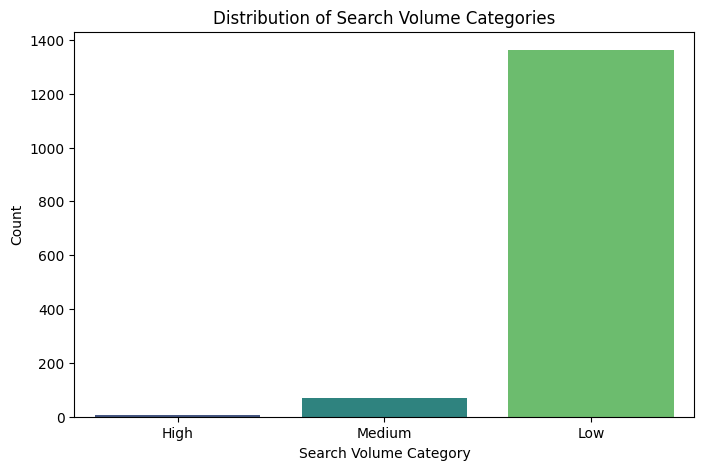

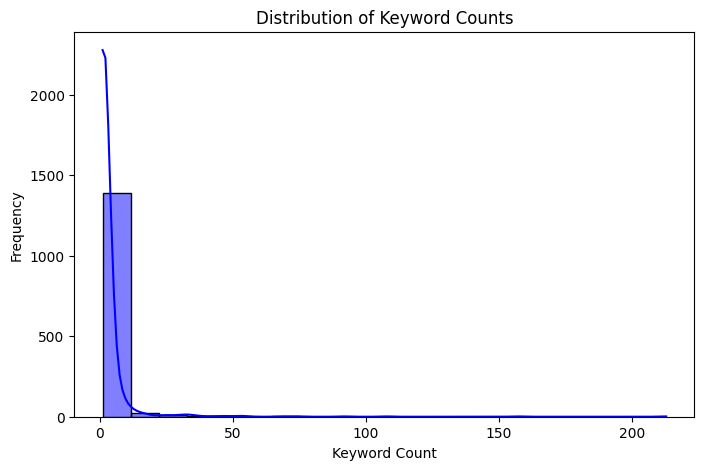

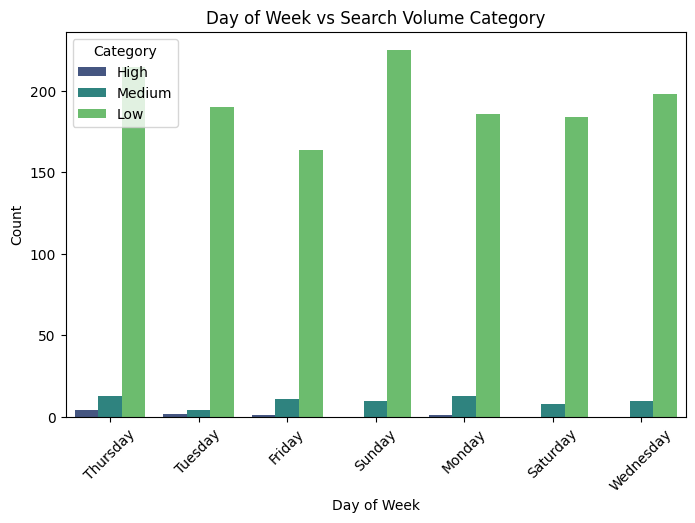

In [79]:
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Search volume (category)', palette="viridis")
plt.title("Distribution of Search Volume Categories")
plt.xlabel("Search Volume Category")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data['Keyword Count'], kde=True, bins=20, color='blue')
plt.title("Distribution of Keyword Counts")
plt.xlabel("Keyword Count")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Day of Week', hue='Search volume (category)', palette="viridis")
plt.title("Day of Week vs Search Volume Category")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.show()

**Prepare features for modeling.**

In [72]:
# Feature Encoding
label_encoder = LabelEncoder()
data['Day of Week Encoded'] = label_encoder.fit_transform(data['Day of Week'].astype(str))

In [73]:
# Selecting features and target
features = ['Hour of Day', 'Day of Week Encoded', 'Keyword Count']
target = 'Search volume (category)'

X = data[features]
y = data[target]

**Split the data for training and evaluation.**

In [82]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


**Use a Random Forest Classifier for prediction.**

In [80]:
# Model Training
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**Evaluate the performance using accuracy and a classification report.**

In [75]:
# Evaluation
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High'])

print(f"Model Accuracy: {accuracy:.2f}\n")
print("Classification Report:\n", report)


Model Accuracy: 0.97

Classification Report:
               precision    recall  f1-score   support

         Low       0.00      0.00      0.00         2
      Medium       0.97      1.00      0.99       272
        High       0.70      0.50      0.58        14

    accuracy                           0.97       288
   macro avg       0.56      0.50      0.52       288
weighted avg       0.95      0.97      0.96       288



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Understand which features contribute most to the predictions.**

<ipython-input-76-f4ae56c2c28d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")


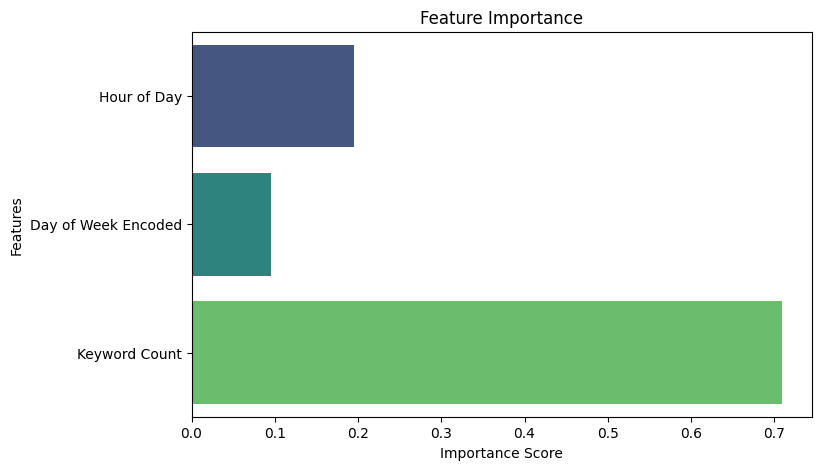

In [76]:
# Visualizing Feature Importance
feature_importance = pd.Series(rf_model.feature_importances_, index=features)
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()